In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier, utils

2024-02-20 14:40:39.711589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 14:40:39.711651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 14:40:39.712444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 14:40:39.718345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 14:40:40.641544: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}

In [ ]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']
input_features_new = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)',
                  'Argument of Periapsis (deg)', 'True Anomaly (deg)']
label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (deg)',
                                                              'True Anomaly (deg)',
                                                              'Longitude (deg)',
                                                              'Latitude (deg)'],
                                      diff_transform_features=['Longitude (deg)',
                                                               'True Anomaly (deg)',
                                                               'Argument of Periapsis (deg)',
                                                               'RAAN (deg)'],
                                      sin_transform_features=[],#['Longitude (deg)', 'Argument of Periapsis (deg)', 'RAAN (deg)'],
                                      sin_cos_transform_features=[],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=True,
                                      with_labels=True,
                                      train_val_split=0.8,
                                      input_stride=2,
                                      padding='zero',
                                      scale=True,
                                      per_object_scaling=False,
                                      pad_location_labels=0,
                                      input_history_steps=16,
                                      input_future_steps=128, #!
                                      input_dtype=np.float32,
                                      seed=181)


=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 16-128 @ stride 2
Scaling: True  
Diff Transforming features: ['Longitude (deg)', 'True Anomaly (deg)', 'Argument of Periapsis (deg)', 'RAAN (deg)']
Adding yeartime features.
Final 14 input features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Longitude (deg)', 'Latitude (deg)', 'Longitude (deg) (diff)', 'True Anomaly (deg) (diff)', 'Argument of Periapsis (deg) (diff)', 'RAAN (deg) (diff)', 'Epoch Year Fraction (sin)', 'Epoch Year Fraction (cos)']
=========================Finished Generator=======================


In [4]:
utils.set_random_seed(42)

train_combined, val_combined = ds_gen.get_datasets(batch_size=1024, 
                                                   label_features=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                                   overview_input_features=['Longitude (deg)', 'RAAN (deg)', 'Eccentricity', 'Latitude (deg)'],
                                                   with_identifier=False, 
                                                   only_nodes=True, 
                                                   shuffle=True, 
                                                   stride=1)
print(train_combined.element_spec)


2024-02-20 14:32:48.437358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 14:32:48.680832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 14:32:48.680906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 14:32:48.684611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 14:32:48.684685: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(5291, shape=(), dtype=int64)
(TensorSpec(shape=(None, 72, 16), dtype=tf.float32, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 72, 16)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 67, 64)               6208      ['Input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 67, 64)               0         ['conv1d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 67, 64)               0         ['activation[0][0]']          
                                                                                              

2024-02-20 14:33:07.082187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-20 14:33:09.615891: I external/local_xla/xla/service/service.cc:168] XLA service 0x87f30a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 14:33:09.615948: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-20 14:33:09.654985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708435989.872864   78477 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 - 12s - loss: 3.8367 - EW_Type_loss: 1.9364 - NS_Type_loss: 1.6833 - EW_Type_accuracy: 0.2504 - NS_Type_accuracy: 0.6751 - val_loss: 2.4427 - val_EW_Type_loss: 1.2574 - val_NS_Type_loss: 0.9630 - val_EW_Type_accuracy: 0.5037 - val_NS_Type_accuracy: 0.7193 - 12s/epoch - 2s/step
Epoch 2/300
6/6 - 0s - loss: 2.2997 - EW_Type_loss: 1.1737 - NS_Type_loss: 0.9012 - EW_Type_accuracy: 0.4689 - NS_Type_accuracy: 0.7165 - val_loss: 1.9670 - val_EW_Type_loss: 0.9779 - val_NS_Type_loss: 0.7629 - val_EW_Type_accuracy: 0.5247 - val_NS_Type_accuracy: 0.7193 - 260ms/epoch - 43ms/step
Epoch 3/300
6/6 - 0s - loss: 1.9182 - EW_Type_loss: 0.9615 - NS_Type_loss: 0.7311 - EW_Type_accuracy: 0.5250 - NS_Type_accuracy: 0.7163 - val_loss: 1.6488 - val_EW_Type_loss: 0.8315 - val_NS_Type_loss: 0.5939 - val_EW_Type_accuracy: 0.6243 - val_NS_Type_accuracy: 0.7193 - 231ms/epoch - 38ms/step
Epoch 4/300
6/6 - 0s - loss: 1.6746 - EW_Type_loss: 0.8639 - NS_Type_loss: 0.5895 - EW_Type_accuracy: 0.6169 - NS_Type_accur

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.20178037881851196,
 0.036241862922906876,
 0.016839884221553802,
 0.987525999546051,
 0.9952750205993652]

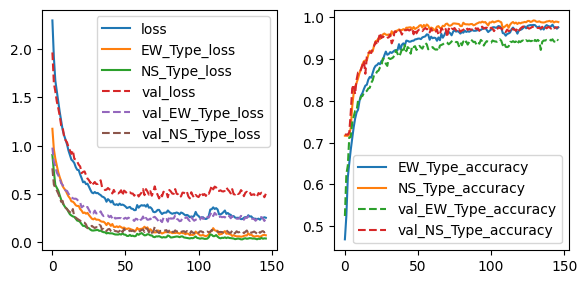

In [5]:
utils.set_random_seed(42)

#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.5, lr_scheduler=[10000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model = prediction_models.Dense_NN(val_combined,
                                         conv1d_layers=[[64,6],[64,6],[64,6]],
                                         conv2d_layers=[],#[32,(6,3)],[32,(6,3)],[32,(6,3)]],
                                         dense_layers=[64,64],
                                         lstm_layers=[],
                                         l2_reg=0.0006,
                                         input_dropout=0.0,
                                         mixed_dropout_dense=0.05,
                                         mixed_dropout_cnn=0.05,
                                         mixed_dropout_lstm=0.0,
                                         mixed_batchnorm=False, # if True, this fucks up inference big time! maybe re-visit?
                                         lr_scheduler=[0.005, 250, 0.9],
                                         output_type='classification',
                                         seed=0)

#dense_model._model = create_timeseries_classification_model((65,6))

dense_model.summary()

# temporary fix to allow class weights
# train_combined= train_combined.map(lambda x,y:(x,y[f'EW_Type']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Type'])) 

# w_0 = 1.05
# w_1 = 1.2
# w_2 = 1.05
# w_3 = 0.65

hist = dense_model.fit(train_combined,
                       val_ds=val_combined,
                       epochs=300,
                       verbose=2,
                       plot_hist=True,
                       save_best_only=False,
                       early_stopping=40,
                       target_metric='val_EW_Type_accuracy',
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
dense_model.evaluate(train_combined)
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

# 
# No transform: 14 71 0.946
# True Anomaly + keep [float64]: 10 76 0.946
# True Anomaly + keep [float32]: 11 78 0.953 -> not better, not worse
# all + keep [float32]: 09 83 0.941
# all dont keep [float32]: 20 75 0.935

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, early_stopping=40, target_metric='val_EW_Type_accuracy', epochs=100, verbose=2, plot_hist=True, callbacks=[])

In [6]:
#dense_model.model.save('submission/models/ew_ns_classifier.hdf5')

In [7]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                confusion_matrix=False,
                                prediction_batches=3,
                                verbose=1)

2024-02-20 14:37:41.013320: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-20 14:37:41.055475: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2/2 [==============================] - 0s 417ms/step


In [8]:
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
majority_df = classifier.apply_one_shot_method(preds_df=pred_df, location_df=ground_truth_df, dirs=['EW', 'NS'])

# ground_truth_df=ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
# majority_df=majority_df.loc[majority_df['TimeIndex']==0]
# ground_truth_df=ground_truth_df.loc[ground_truth_df['Direction']=='EW']
# majority_df=majority_df.loc[majority_df['Direction']=='EW']

# 0.95 with 3-layer cnn and 128@2 horizon

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

Precision: 0.954
TP: 1756 FP: 84


In [11]:
print(dense_model.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0032804995>


In [8]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')

#0.12 0.92 0.950 (no dropout, strong overfitting, no ft-transform)

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
